In [1]:
import numpy as np
from qiskit import QuantumCircuit, execute
from qiskit.providers.aer import QasmSimulator
from qiskit.visualization import *
import qiskit
import matplotlib.pyplot as plt

In [2]:
num_qubits = 16

In [3]:
def create_random_states():

    alice_state = np.random.randint(0, 2, size=num_qubits)
    eve_basis = np.random.randint(0, 2, size=num_qubits)
    bob_basis = np.random.randint(0, 2, size=num_qubits)

    
    return alice_state, eve_basis, bob_basis

In [4]:
# function to define the circuit for an exchange of bit string
def make_b92_circ(enc_state, meas_basis, noise_prob):
    
    num_qubits = len(enc_state)

    b92 = QuantumCircuit(num_qubits)

    for index in range(len(enc_state)):
        if enc_state[index] == 1:
            b92.h(index)
    
    b92.barrier()
    
    noise = []

    for index in range(len(enc_state)):
        if np.random.random() <= noise_prob:
            b92.x(index)
            noise.append(1)
        else:
            noise.append(0)
            
            
    #print(f"Noise:\t\t {np.array2string(np.array(list(noise), dtype=int), separator='')}")
    
    
    b92.barrier()  

    for index in range(len(meas_basis)):
        if meas_basis[index] == 1:
            b92.h(index)

    # Do not change below this line
    b92.measure_all()
#     print(b92)
    return b92

In [5]:
# function to define the circuit for an exchange of bit string
def make_eaves_circ(enc_basis, enc_state, meas_basis, noise_prob):
    
    num_qubits = len(enc_state)

    b92 = QuantumCircuit(num_qubits)
        
    
    for index in range(num_qubits):
        if (enc_basis[index] == 0 and enc_state[index] == 1):
            b92.x(index)
        elif (enc_basis[index] == 1 and enc_state[index] == 0):
            b92.h(index)
        elif (enc_basis[index] == 1 and enc_state[index] == 1):
            b92.x(index)
            b92.h(index)
            
    b92.barrier()
    
    noise = []

    for index in range(len(enc_state)):
        if np.random.random() <= noise_prob:
            b92.x(index)
            noise.append(1)
        else:
            noise.append(0)
            
            
    #print(f"Noise:\t\t {np.array2string(np.array(list(noise), dtype=int), separator='')}")
    
    
    b92.barrier()
            
            
    for index in range(len(meas_basis)):
        if meas_basis[index] == 1:
            b92.h(index)
    
    
    b92.measure_all()
#     print(b92)
    return b92

In [6]:
def b92_sifting(enc_state, meas_basis, meas_result):
    
    num_qubits = len(enc_state)
    
    sender_key = ''
    receiver_key = ''
    
    for i in range(len(meas_result)):
      if meas_result[i] == '1':
        sender_key+=str(enc_state[i])
        receiver_key+=str((meas_basis[i]+1)%2)
        
    return (sender_key, receiver_key)

In [7]:
diff_bits_rate = []
same_key = 0
iterations = 200
noise_prob = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
key_rate_arr = []

print(f"Initial key length = {num_qubits}")
print(f"\n")

for noise in noise_prob:
    
    key_list_bob = []
    for index in range (0,iterations):

        alice_state, eve_basis, bob_basis = create_random_states()
        
        #print(f"Alice's State:\t {np.array2string(alice_state, separator='')}")
    
        #Alice sends the bits to Bob but Eve eavesdrops in between
        b92_circ = make_b92_circ(alice_state, eve_basis, noise/2)
        
        #print(f"Eve's Basis:\t {np.array2string(eve_basis, separator='')}")

        #final result got by Eve after measurement
        eve_res = execute(
                b92_circ.reverse_bits(),
                backend=QasmSimulator(),
                shots=1 
            ).result().get_counts().most_frequent()

        eve_state = np.array(list(eve_res), dtype=int)
        
        #print(f"Eve's result:\t {np.array2string(eve_state, separator='')}")

        # Eve updates the state to send it to Bob
    #     eve_state = ''.join([str(int(eve_res[i]) ^ int(eve_basis[i])) for i in range(len(eve_res))])

    #     eve_state = np.array(list(eve_state), dtype=int)

        #Bob measures the circuit thinking that it was sent by Alice
        b92_circ2 = make_eaves_circ(eve_basis, eve_state, bob_basis, noise/2)

        bob_res = execute(
                b92_circ2.reverse_bits(),
                backend=QasmSimulator(),
                shots=1
            ).result().get_counts().most_frequent()

    #     print(bob_res)

        
        #print(f"Bob's Basis:\t {np.array2string(bob_basis, separator='')}")
        #print (f"Bob's result:\t [{bob_res}]")

        # key sifting takes place to get the final key to be used
        alice_key, bob_key = b92_sifting(alice_state, bob_basis, bob_res)

    #    print(f"Alice's final key: \t{alice_key}")
    #    print(f"Bob's final key: \t{bob_key}")
        key_list_bob.append(bob_key)

        same_bit = 0

       # for i in range(len(bob_key)):
       #     if bob_key[i] == alice_key[i]:
       #         same_bit += 1
       # diff_bits_rate.append((len(bob_key)-same_bit)/len(bob_key))
       
       # if alice_key == bob_key:
       #     same_key += 1

    avg_key_length = sum( map( len, key_list_bob))/ len( key_list_bob)
    #avg_bit_error = sum( diff_bits_rate)*100/ len( diff_bits_rate)
    key_rate_arr.append(avg_key_length/num_qubits)
    print(f"Final average key length after {iterations} iterations =  {avg_key_length}")
    print(f"Key rate: {avg_key_length/num_qubits}")
#    print(f"Keys are same {same_key} times out of {iterations}")
#    print(f"Bit error rate is {avg_bit_error}%")
    #print(key_list_bob)
    print(f"\n")
    
print(f"Noise Probability:\t {noise_prob}")
print(f"The key rate:\t\t{key_rate_arr}")

Initial key length = 16


Final average key length after 200 iterations =  6.02
Key rate: 0.37625


Final average key length after 200 iterations =  6.25
Key rate: 0.390625


Final average key length after 200 iterations =  6.33
Key rate: 0.395625


Final average key length after 200 iterations =  6.355
Key rate: 0.3971875


Final average key length after 200 iterations =  6.475
Key rate: 0.4046875


Final average key length after 200 iterations =  6.78
Key rate: 0.42375


Final average key length after 200 iterations =  6.825
Key rate: 0.4265625


Final average key length after 200 iterations =  6.935
Key rate: 0.4334375


Final average key length after 200 iterations =  7.03
Key rate: 0.439375


Final average key length after 200 iterations =  6.67
Key rate: 0.416875


Final average key length after 200 iterations =  6.955
Key rate: 0.4346875


Noise Probability:	 [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
The key rate:		[0.37625, 0.390625, 0.395625, 0.3971875, 0.4046875, 0.

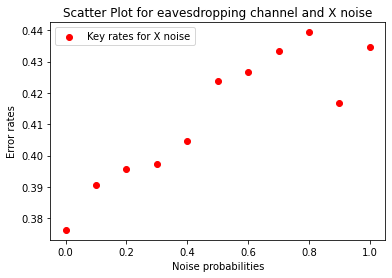

In [8]:
plt.scatter(noise_prob,key_rate_arr, label="Key rates for X noise",color="r")
plt.title("Scatter Plot for eavesdropping channel and X noise")
plt.xlabel("Noise probabilities")
plt.ylabel("Error rates")
plt.legend()
plt.show()